<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/SML2020/09_logistic_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 糖尿病をロジスティック回帰で予測してみる

* 有名なPima Indians Diabetes Databaseを使う

https://www.kaggle.com/uciml/pima-indians-diabetes-database

### 1) データの読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
diabetes = pd.read_csv('diabetes.csv')

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

In [5]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### 2) テストデータの分離

In [6]:
from sklearn.model_selection import train_test_split

# （この分割は変えないようにしてください。）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 123)



---



（ここから自由に試行錯誤をスタートさせましょう。）



---



### -1) 最初に、このままロジスティック回帰のデフォルトの設定で学習、そして、テストセットで評価する。（7月17日、追記）

In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=123)
logreg.fit(X_train, y_train)
print('test score: {:.4f}'.format(logreg.score(X_test, y_test)))

test score: 0.8103


実は、これより良くするのが至難の技のようです。

つまり、あまり特徴量をいじらないのが良い、ということかもしれません。

あるいは、テストセットの分割の仕方が、たまたま、この最もシンプルな方法が良くなるものだっただけかもしれません。

そこで、課題の範囲からは外れますが、SVMを試してみます。

In [8]:
from sklearn.svm import SVC

svc = SVC(random_state=123)
svc.fit(X_train, y_train)
print('test score: {:.4f}'.format(svc.score(X_test, y_test)))

test score: 0.7759


SVMではそこそこの分類性能です。

なので、何か、今回のテストセットが、デフォルト設定のままのロジスティック回帰に特に都合の良い分割になっていた可能性はあります・・・。

以下、特徴量エンジニアリングの練習だと思って、お付き合いください。

### A) 最初に交差検証の準備をしておく

In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

### B) 交差検証による評価のための関数を定義しておく

In [10]:
from sklearn.linear_model import LogisticRegression

def cv(skf, X_train, y_train, args={}):
  scores = list()
  for train_index, valid_index in skf.split(X_train, y_train):

    # ロジスティック回帰の学習
    if not 'max_iter' in args:
      logreg = LogisticRegression(**args, max_iter=1000, random_state=123)
    else:
      logreg = LogisticRegression(**args, random_state=123)
    logreg.fit(X_train.iloc[train_index], y_train.iloc[train_index])

    # 検証データでの評価
    score = logreg.score(X_train.iloc[valid_index], y_train.iloc[valid_index])
    print('score: {:.4f}'.format(score))
    scores.append(score)

  print('mean score: {:.4f}'.format(np.array(scores).mean()), end=' ')
  print('{', ' '.join(['"{:s}":{:s}'.format(str(k), str(args[k])) for k in args]), '}')

### C) デフォルト設定のロジスティック回帰の性能を評価する

In [11]:
cv(skf, X_train, y_train)

score: 0.8182
score: 0.7879
score: 0.7385
score: 0.7692
score: 0.7692
score: 0.7538
score: 0.7538
score: 0.7846
score: 0.7231
score: 0.7385
mean score: 0.7637 {  }


### D) BloodPressureへの対応

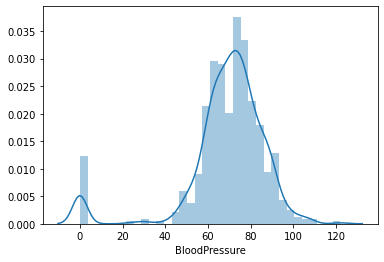

In [12]:
# まず、属性「BloodPressure」について、ヒストグラムを描いてよくよく眺める。

sns.distplot(X_train['BloodPressure'])

In [13]:
# 0という値がけっこうあるらしい。実は、これは欠測値。そこで、中央値で埋めることにする。
# （この前処理の仕方で正しいという保証はありません。）

bp_median = np.median(X_train[X_train.BloodPressure != 0]['BloodPressure'])
print(bp_median)
X_train = X_train.replace({'BloodPressure':0}, bp_median)

72.0


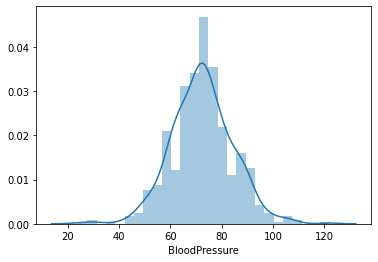

In [14]:
# もう一度、ヒストグラムを描く。

sns.distplot(X_train['BloodPressure'])

In [15]:
# test dataの「BloodPressure」の欠測値も、training dataと同じ値で埋める。
# この作業は、training dataから得られる情報しか使っていないので、ズルはしていない。

X_test = X_test.replace({'BloodPressure':0}, bp_median)

In [16]:
cv(skf, X_train, y_train)

score: 0.8333
score: 0.8182
score: 0.7538
score: 0.7538
score: 0.7692
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7077
score: 0.7385
mean score: 0.7698 {  }


### E) BMIへの対応

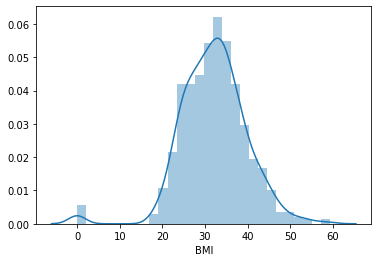

In [17]:
# 次に、training dataの「BMI」のヒストグラムを描いてみる

sns.distplot(X_train['BMI'])

32.4


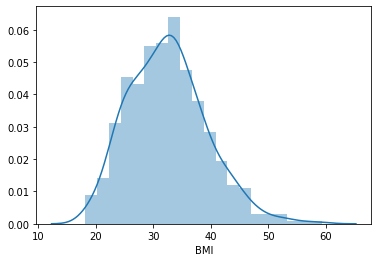

In [18]:
# やはり欠測値の部分が0とされているようなので、先ほどと同様、中央値で埋める。

bmi_median = np.median(X_train[X_train.BMI != 0]['BMI'])
print(bmi_median)
X_train = X_train.replace({'BMI':0}, bmi_median)
sns.distplot(X_train['BMI'])

In [19]:
# test dataのBMIの欠測値も、同じ値で埋める 

X_test = X_test.replace({'BMI':0}, bmi_median)

In [20]:
cv(skf, X_train, y_train)

score: 0.8333
score: 0.8030
score: 0.7846
score: 0.7538
score: 0.7692
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7077
score: 0.7385
mean score: 0.7713 {  }


### F) Glucoseへの対応

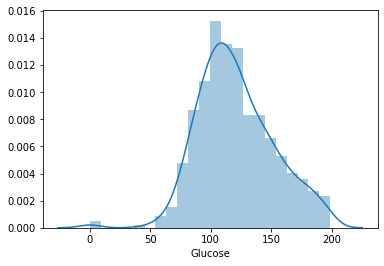

In [21]:
sns.distplot(X_train['Glucose'])

117.0


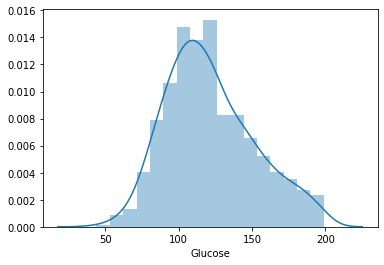

In [22]:
glucose_median = np.median(X_train[X_train.Glucose != 0]['Glucose'])
print(glucose_median)
X_train = X_train.replace({'Glucose':0}, glucose_median)
sns.distplot(X_train['Glucose'])

In [23]:
cv(skf, X_train, y_train)

score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7538
score: 0.8000
score: 0.7077
score: 0.7385
mean score: 0.7759 {  }


In [24]:
# test dataのGlucoseの欠測箇所も、同じ値で埋める 

X_test = X_test.replace({'Glucose':0}, glucose_median)

ここまでの交差検証でのベスト・スコアは0.7759。

### G) DiabetesPedigreeFunctionへの対応

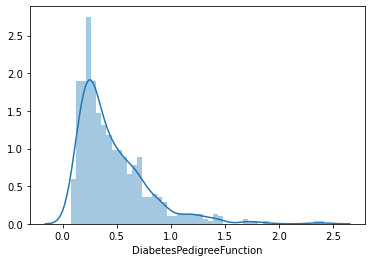

In [25]:
sns.distplot(X_train['DiabetesPedigreeFunction'], bins=50)

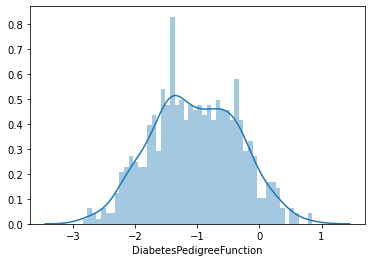

In [26]:
from scipy.stats import boxcox

X_train_boxcox = X_train.copy()
X_train_boxcox.DiabetesPedigreeFunction, maxlog = boxcox(X_train.DiabetesPedigreeFunction)
sns.distplot(X_train_boxcox['DiabetesPedigreeFunction'], bins=50)

In [27]:
cv(skf, X_train_boxcox, y_train)

score: 0.8182
score: 0.8333
score: 0.7692
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7692
score: 0.8000
score: 0.7077
score: 0.7385
mean score: 0.7744 {  }


悪くなったので不採用。

### H) SkinThicknessとInsulin: 線形回帰で欠測値を埋める

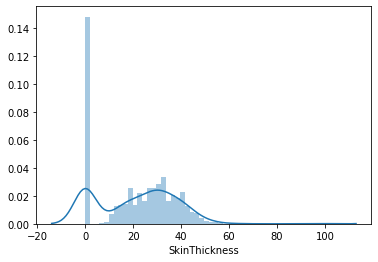

In [28]:
sns.distplot(X_train['SkinThickness'], bins=50)

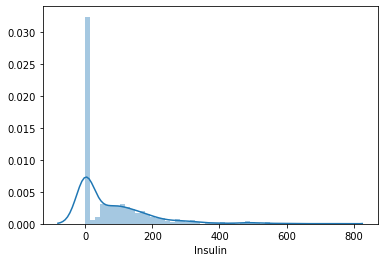

In [29]:
sns.distplot(X_train['Insulin'], bins=50)

In [30]:
(X_train['SkinThickness'] == 0).sum()

191

In [31]:
(X_train['Insulin'] == 0).sum()

314

In [32]:
((X_train['SkinThickness'] == 0) & (X_train['Insulin'] == 0)).sum()

191

In [33]:
for i in X_train.index[X_train['SkinThickness'] == 0]:
  if not i in X_train.index[X_train['Insulin'] == 0]:
    print('No')

SkinThicknessが0の個体は、必ずInsulinも0になっているらしい。

ただし、これは訓練データだけでこうなっているだけかもしれないので、この事実に依存して何かをすることはしない。

In [34]:
# LassoでSkinThicknessとInsulinの欠測部分を埋める

from sklearn.linear_model import Lasso

columns = X_train.columns[(X_train.columns != 'SkinThickness') & (X_train.columns != 'Insulin')]

for alpha in np.power(10.0, np.arange(12) - 5):

  X_train_copy = X_train.copy()

  indices = (X_train['SkinThickness'] != 0)
  reg = Lasso(alpha=alpha)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
  X_train_copy.loc[~ indices, 'SkinThickness'] = reg.predict(X_train.loc[~ indices, columns])

  indices = (X_train['Insulin'] != 0)
  reg = Lasso(alpha=alpha)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
  X_train_copy.loc[~ indices, 'Insulin'] = reg.predict(X_train.loc[~ indices, columns])

  print('-'*8, alpha, '-'*16)
  cv(skf, X_train_copy, y_train)

-------- 1e-05 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.0001 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.001 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.01 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.1 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 1.0 ---------

In [35]:
# Ridge回帰でSkinThicknessとInsulinの欠測部分を埋める

from sklearn.linear_model import Ridge

columns = X_train.columns[(X_train.columns != 'SkinThickness') & (X_train.columns != 'Insulin')]

for alpha in np.power(10.0, np.arange(12) - 5):

  X_train_copy = X_train.copy()

  indices = (X_train['SkinThickness'] != 0)
  reg = Ridge(alpha=alpha)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
  X_train_copy.loc[~ indices, 'SkinThickness'] = reg.predict(X_train.loc[~ indices, columns])

  indices = (X_train['Insulin'] != 0)
  reg = Ridge(alpha=alpha)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
  X_train_copy.loc[~ indices, 'Insulin'] = reg.predict(X_train.loc[~ indices, columns])

  print('-'*8, alpha, '-'*16)
  cv(skf, X_train_copy, y_train)

-------- 1e-05 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.0001 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.001 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.01 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.1 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 1.0 ---------

悪くなったので不採用。

### I) SkinThicknessとInsulin: それぞれk-近傍法で値を埋める

In [36]:
# k-NNでSkinThicknessの欠測部分を埋める

from sklearn.neighbors import KNeighborsClassifier

columns = X_train.columns[(X_train.columns != 'SkinThickness') & (X_train.columns != 'Insulin')]

for k in range(1, 21):

  X_train_copy = X_train.copy()

  indices = (X_train['SkinThickness'] != 0)
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
  X_train_copy.loc[~ indices, 'SkinThickness'] = knn.predict(X_train.loc[~ indices, columns])

  indices = (X_train['Insulin'] != 0)
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
  X_train_copy.loc[~ indices, 'Insulin'] = knn.predict(X_train.loc[~ indices, columns])

  print('-'*8, k, '-'*16)
  cv(skf, X_train_copy, y_train)

-------- 1 ----------------
score: 0.8333
score: 0.7727
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7538
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.7385
mean score: 0.7698 {  }
-------- 2 ----------------
score: 0.8333
score: 0.7879
score: 0.7846
score: 0.7385
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7744 {  }
-------- 3 ----------------
score: 0.8333
score: 0.7879
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.8000
score: 0.7231
score: 0.7385
mean score: 0.7729 {  }
-------- 4 ----------------
score: 0.8333
score: 0.7879
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.7846
score: 0.7231
score: 0.7385
mean score: 0.7714 {  }
-------- 5 ----------------
score: 0.8333
score: 0.7879
score: 0.7846
score: 0.7385
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.7385
mean score: 0.7729 {  }
-------- 6 ----------------
score: 0.833

In [37]:
# k=9を採用

k = 9

X_train_copy = X_train.copy()

indices = (X_train['SkinThickness'] != 0)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
X_train_copy.loc[~ indices, 'SkinThickness'] = knn.predict(X_train.loc[~ indices, columns])

indices = (X_train['Insulin'] != 0)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
X_train_copy.loc[~ indices, 'Insulin'] = knn.predict(X_train.loc[~ indices, columns])

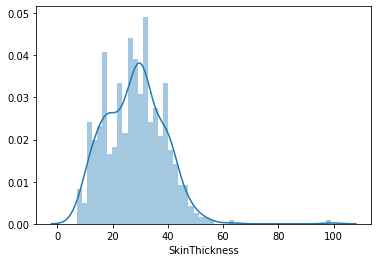

In [38]:
sns.distplot(X_train_copy['SkinThickness'], bins=50)

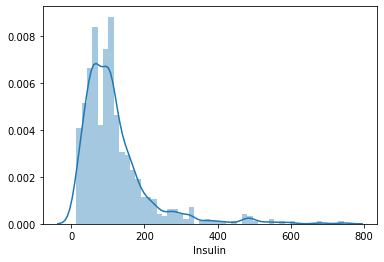

In [39]:
sns.distplot(X_train_copy['Insulin'], bins=50)

In [40]:
cv(skf, X_train_copy, y_train)

score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.7385
mean score: 0.7790 {  }


In [41]:
# k=9を使って、テストデータの欠測箇所も埋めておく

X_test_copy = X_test.copy()

k = 9

indices = (X_train['SkinThickness'] != 0)
test_missing = (X_test['SkinThickness'] == 0)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
X_test_copy.loc[test_missing, 'SkinThickness'] = knn.predict(X_test.loc[test_missing, columns])

indices = (X_train['Insulin'] != 0)
test_missing = (X_test['Insulin'] == 0)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
X_test_copy.loc[test_missing, 'Insulin'] = knn.predict(X_test.loc[test_missing, columns])

In [42]:
print((X_test_copy.SkinThickness == 0).sum())
print((X_test_copy.Insulin == 0).sum())

0
0


In [43]:
X_train = X_train_copy
X_test = X_test_copy

In [44]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,3.796012,121.512270,72.374233,27.943252,117.987730,32.515184,0.460816,33.291411
std,3.325152,30.146975,11.921575,10.474671,94.510997,6.801301,0.321493,11.801392
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,19.000000,61.000000,27.500000,0.238000,24.000000
50%,3.000000,117.000000,72.000000,28.000000,100.000000,32.400000,0.364500,29.000000
75%,6.000000,141.000000,80.000000,35.000000,140.000000,36.600000,0.605000,41.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,59.400000,2.420000,81.000000


### J) スケーラーを使ってみる。

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_temp = X_train.copy()
X_train_temp[X_train.columns] = scaler.transform(X_train)
cv(skf, X_train_temp, y_train)

score: 0.8030
score: 0.8030
score: 0.7538
score: 0.7385
score: 0.7846
score: 0.7692
score: 0.7231
score: 0.7846
score: 0.7231
score: 0.7385
mean score: 0.7621 {  }


In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_temp = X_train.copy()
X_train_temp[X_train.columns] = scaler.transform(X_train)
cv(skf, X_train_temp, y_train)

score: 0.8182
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.8000
score: 0.7077
score: 0.7385
mean score: 0.7744 {  }


いずれも不採用。

### K) 正則化パラメータCをチューニングする。

In [47]:
for C in np.power(10.0, np.arange(13) - 5):
  cv(skf, X_train, y_train, {'C':C})

score: 0.7273
score: 0.7727
score: 0.7385
score: 0.6923
score: 0.7846
score: 0.7846
score: 0.6769
score: 0.7385
score: 0.7231
score: 0.7231
mean score: 0.7362 { "C":1e-05 }
score: 0.8485
score: 0.8182
score: 0.7692
score: 0.6769
score: 0.7538
score: 0.7538
score: 0.6923
score: 0.7538
score: 0.7231
score: 0.7538
mean score: 0.7544 { "C":0.0001 }
score: 0.8182
score: 0.8030
score: 0.7692
score: 0.7385
score: 0.7692
score: 0.7846
score: 0.7077
score: 0.7846
score: 0.7385
score: 0.7692
mean score: 0.7683 { "C":0.001 }
score: 0.8333
score: 0.7727
score: 0.7692
score: 0.7538
score: 0.7692
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7077
score: 0.7538
mean score: 0.7683 { "C":0.01 }
score: 0.8333
score: 0.7879
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7538
score: 0.7538
score: 0.8154
score: 0.7077
score: 0.7538
mean score: 0.7714 { "C":0.1 }
score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.73

In [48]:
for C in np.power(10.0, np.arange(13) - 5):
  cv(skf, X_train, y_train, {'C':C, 'penalty':'l1', 'solver':'liblinear', 'max_iter':5000})

score: 0.6515
score: 0.6515
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6462
score: 0.6462
mean score: 0.6565 { "C":1e-05 "penalty":l1 "solver":liblinear "max_iter":5000 }
score: 0.6515
score: 0.6515
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6462
score: 0.6462
mean score: 0.6565 { "C":0.0001 "penalty":l1 "solver":liblinear "max_iter":5000 }
score: 0.6364
score: 0.6515
score: 0.6615
score: 0.6308
score: 0.6769
score: 0.6769
score: 0.6154
score: 0.6615
score: 0.6615
score: 0.6308
mean score: 0.6503 { "C":0.001 "penalty":l1 "solver":liblinear "max_iter":5000 }
score: 0.7121
score: 0.7273
score: 0.7231
score: 0.6615
score: 0.6308
score: 0.6769
score: 0.6000
score: 0.6769
score: 0.6923
score: 0.7231
mean score: 0.6824 { "C":0.01 "penalty":l1 "solver":liblinear "max_iter":5000 }
score: 0.7576
score: 0.7424
score: 0.7231
score: 0.7231
score: 0.6923
score: 0.7077
score: 0.6615
score: 0.7077
scor

デフォルト値を採用。

In [49]:
cv(skf, X_train, y_train)

score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.7385
mean score: 0.7790 {  }


### L) テストデータで最終評価

In [50]:
logreg = LogisticRegression(C=10, max_iter=1000, random_state=123)
logreg.fit(X_train, y_train)
print('test score: {:.4f}'.format(logreg.score(X_test, y_test)))

test score: 0.7759


In [51]:
# The area under ROC curveも計算してみる。

from sklearn.metrics import roc_auc_score

y_test_pred = logreg.predict(X_test)
print('ROC AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_pred)))

ROC AUC: 0.7399
